In [1]:
import os 
import timm
import torch
import torch
import torch.nn as nn
import requests
import timm
import math
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchvision

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from multissl.models import FastSiam

In [3]:
def clean_state_dict(
    state_dict,
    prefix_to_strip="backbone.",
    skip_if_contains=None
):
    """
    Create a new state_dict with:
      1) The specified prefix stripped from the start of each key.
      2) Certain keys *entirely removed* if they match a skip pattern.

    :param state_dict: (dict) The original state_dict.
    :param prefix_to_strip: (str) If a key starts with this prefix, remove that prefix.
    :param skip_if_contains: (list of str or None)
            If not None, any key containing ANY of these substrings is skipped entirely.
    :return: (dict) A new state_dict with modified/filtered keys.
    """
    if skip_if_contains is None:
        skip_if_contains = []

    new_state_dict = {}
    for key, value in state_dict.items():
        # 1) Check if we should skip this key entirely
        #    (if the key contains any of the "skip" substrings)
        if any(skip_str in key for skip_str in skip_if_contains):
            continue

        # 2) Strip prefix if present
        if key.startswith(prefix_to_strip):
            new_key = key[len(prefix_to_strip):]
        else:
            new_key = key

        new_state_dict[new_key] = value

    return new_state_dict


In [4]:
from multissl.data import tifffile_loader
from multissl.data.transforms import UIntToFloat, Transpose, ToTensor
from torchvision import transforms
import cv2

def load_tiff_tensor(path, image_size=None):
    """
    Load a TIFF file, optionally resize to (image_size, image_size), 
    then run through the transform pipeline to get a PyTorch tensor.
    """
    # 1) Read as NumPy array
    image_array = tifffile_loader(path)  # shape could be H×W or H×W×C
    
    # 2) Optionally resize if image_size is given
    if image_size is not None:
        # If image_array is (H, W) or (H, W, C), handle both
        if image_array.ndim == 2:
            # Grayscale => H×W
            image_array = cv2.resize(image_array, (image_size, image_size),
                                     interpolation=cv2.INTER_AREA)
        elif image_array.ndim == 3:
            # Color => H×W×C
            # Note cv2.resize wants (W, H) as the second argument
            h, w, c = image_array.shape
            image_array = cv2.resize(image_array, (image_size, image_size),
                                     interpolation=cv2.INTER_AREA)
        else:
            raise ValueError(f"Unsupported shape {image_array.shape}.")
    base = [UIntToFloat(), Transpose(), ToTensor()]
    # 3) Apply transform pipeline (normalization, transpose, tensor)
    pipeline = transforms.Compose(base) 
      # shape will end up as (C, H, W)
    
    return pipeline(image_array).unsqueeze(0), image_array
def modify_resnet_for_4_channels(resnet, in_channels):
    """Modifies the first ResNet conv layer to accept 4-channel input."""
    old_conv = resnet.conv1
    new_conv = nn.Conv2d(
        in_channels,  # Change from 3 to 4 channels
        old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )
        # Reinitialize new conv weights while keeping pretrained filter values
    with torch.no_grad():
        new_conv.weight[:, :3] = old_conv.weight  # Copy original RGB filters
        new_conv.weight[:, 3] = old_conv.weight[:, 0]  # Initialize NIR with Red channel weights
    
    resnet.conv1 = new_conv  # Replace conv1 with modified conv
    return resnet

class Flatten(nn.Module):
    """Simple module to flatten from [B, C, H, W] -> [B, C*H*W] or [B, C, 1, 1] -> [B, C]"""
    def forward(self, x):
        return x.flatten(start_dim=1)


In [5]:
state = "../checkpoints_512_r50_view4/last.ckpt"
state_dict= torch.load(state)["state_dict"]
state_dict = clean_state_dict(state_dict, prefix_to_strip = "backbone.", skip_if_contains=["prediction_head", "projection_head"])

In [6]:
resnet = torchvision.models.resnet50(weights=None)
backbone_dim = 2048
resnet = modify_resnet_for_4_channels(resnet, 4)

# Remove final FC layer and store the feature extractor
modules = list(resnet.children())[:-1]
modules.append(Flatten())
resnet = nn.Sequential(*modules)
resnet.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
sample_url = "../../msdata/data/chipped_224/3M_SUNCAL_3m_uk_vineyard_east_july_DJI_20240714105409_0078_MS_300_2304.tif"
x, img = load_tiff_tensor(sample_url, image_size=224)  # shape [1,4,224,224]

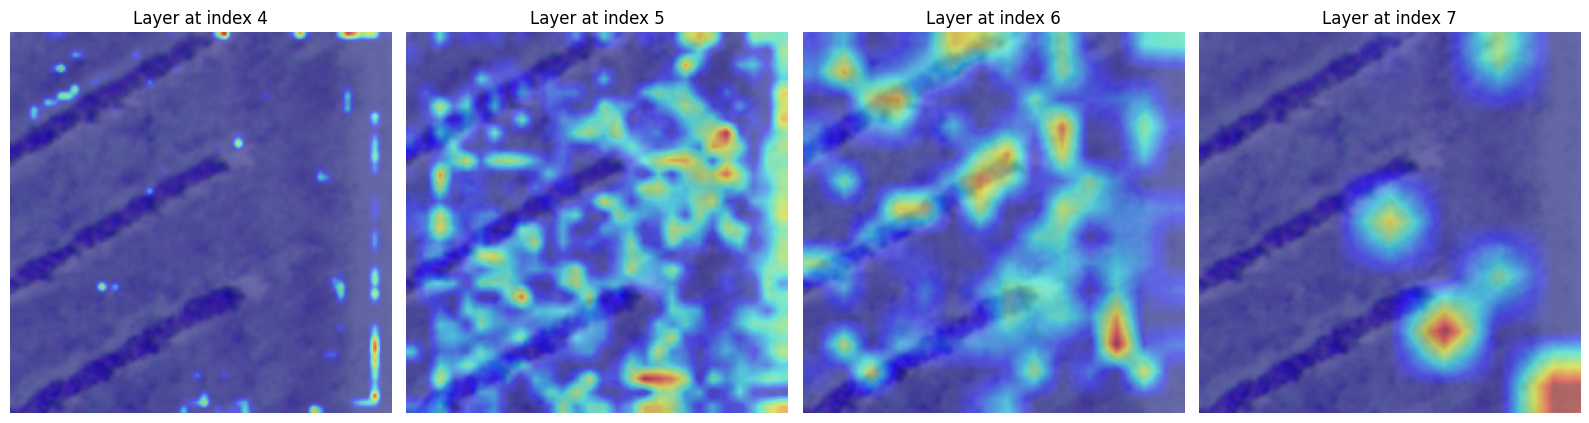

In [12]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# Grad-CAM Class Implementation
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Args:
            model (torch.nn.Module): The full model.
            target_layer (torch.nn.Module): The layer to inspect (usually a conv or a sequential block).
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        # Zero gradients
        self.model.zero_grad()
        # Backward pass for the target class score
        loss = output[0, target_class]
        loss.backward(retain_graph=True)
        # Global average pooling on gradients to get channel-wise weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        # Compute the weighted combination of activation maps
        grad_cam_map = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        # Upsample to the size of the input image
        grad_cam_map = F.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        # Normalize the heatmap between 0 and 1
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map


resnet.eval()

# Layers of interest (indices in the Sequential model):
# Index 4: layer1, 5: layer2, 6: layer3, 7: layer4.
target_indices = [4, 5, 6, 7]
grad_cam_maps = {}


# Run one forward pass to determine the target class for a consistent comparison.
overall_output = resnet(x)
target_class = overall_output.argmax(dim=1).item()

# For each layer index, create a GradCAM instance, compute its heatmap, and then remove the hooks.
for idx in target_indices:
    target_layer = resnet[idx][2].conv3
    grad_cam = GradCAM(resnet, target_layer)
    cam_map = grad_cam(x, target_class=10)
    grad_cam_maps[idx] = cam_map
    grad_cam.remove_hooks()  # Clean up hooks

# Plot all the Grad-CAM maps in one figure (overlayed on the original image).
fig, axs = plt.subplots(1, len(target_indices), figsize=(16, 5))

for ax, idx in zip(axs, target_indices):
    ax.imshow(img)
    ax.imshow(grad_cam_maps[idx], cmap='jet', alpha=0.5)  # Overlay with transparency
    ax.set_title(f'Layer at index {idx}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [10]:
target_class

995

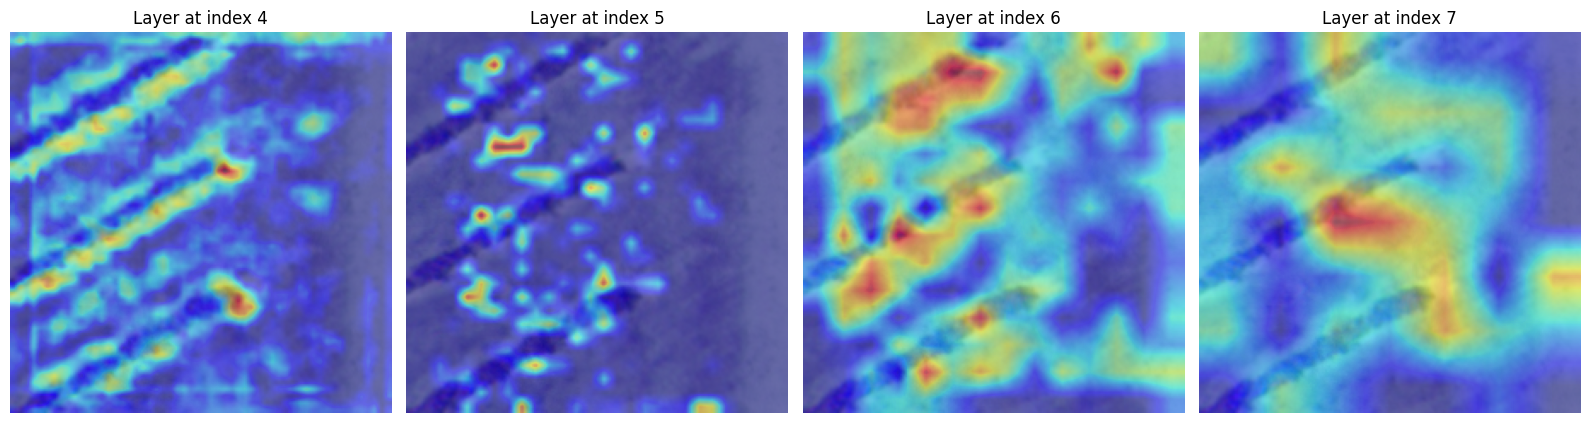

In [71]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# Grad-CAM Class Implementation
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Args:
            model (torch.nn.Module): The full model.
            target_layer (torch.nn.Module): The layer to inspect (usually a conv or a sequential block).
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        # Zero gradients
        self.model.zero_grad()
        # Backward pass for the target class score
        loss = output[0, target_class]
        loss.backward(retain_graph=True)
        # Global average pooling on gradients to get channel-wise weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        # Compute the weighted combination of activation maps
        grad_cam_map = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        # Upsample to the size of the input image
        grad_cam_map = F.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        # Normalize the heatmap between 0 and 1
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map


resnet.eval()

# Layers of interest (indices in the Sequential model):
# Index 4: layer1, 5: layer2, 6: layer3, 7: layer4.
target_indices = [4, 5, 6, 7]
grad_cam_maps = {}


# Run one forward pass to determine the target class for a consistent comparison.
overall_output = resnet(x)
target_class = overall_output.argmax(dim=1).item()

# For each layer index, create a GradCAM instance, compute its heatmap, and then remove the hooks.
for idx in target_indices:
    target_layer = resnet[idx][1].conv2
    grad_cam = GradCAM(resnet, target_layer)
    cam_map = grad_cam(x, target_class=target_class)
    grad_cam_maps[idx] = cam_map
    grad_cam.remove_hooks()  # Clean up hooks

# Plot all the Grad-CAM maps in one figure (overlayed on the original image).
fig, axs = plt.subplots(1, len(target_indices), figsize=(16, 5))

for ax, idx in zip(axs, target_indices):
    ax.imshow(img)
    ax.imshow(grad_cam_maps[idx], cmap='jet', alpha=0.5)  # Overlay with transparency
    ax.set_title(f'Layer at index {idx}')
    ax.axis('off')
plt.tight_layout()
plt.show()
